In [1]:
import numpy as np
import torch 
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
%matplotlib inline

print("Import succesfull !!")

Import succesfull !!


## Loading the data

In [0]:
dataset = torchvision.datasets.MNIST(root='data/',
                                     train=True,
                                     download=True,
                                     transform=transforms.ToTensor())

In [3]:
dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train
    StandardTransform
Transform: ToTensor()

### Preprocessing

In [0]:
def split_indices(len, val_split):
  split_point = int(len*val_split)
  idxs = np.random.permutation(len)
  return idxs[split_point:], idxs[:split_point]

In [5]:
train_idxs, val_idxs = split_indices(len(dataset), 0.2)
print(f"Number of samples in the training set: {len(train_idxs)}")
print(f"Number of samples in the validation set: {len(val_idxs)}")

Number of samples in the training set: 48000
Number of samples in the validation set: 12000


### Loading the data into Batches

In [0]:
batch_size = 100

train_sampler = SubsetRandomSampler(train_idxs)
val_sampler = SubsetRandomSampler(val_idxs)
train_dl = DataLoader(dataset, batch_size, sampler=train_sampler)
val_dl = DataLoader(dataset, batch_size, sampler=val_sampler)

## Defining a Model with 1 hidden layer

In [0]:
class MnistModel(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()
    # hidden layer
    self.linear1 = nn.Linear(input_size, hidden_size)
    # output layer
    self.linear2 = nn.Linear(hidden_size, output_size)
  
  def forward(self, xb):
    # Flatten
    xb = xb.view(xb.size(0), -1)
    # feed into hidden
    output = self.linear1(xb)
    # apply relu activation function
    output = F.relu(output)
    # feed into output layer
    output = self.linear2(output)
    return output

In [0]:
# Now lets create the model 
input_size = 28*28
output_size = 10
hidden_size = 64

model = MnistModel(input_size, hidden_size, output_size)

In [9]:
 # lets look at the iniial loss of a single batch of data
 for xb, yb in train_dl: 
   outputs = model(xb)
   loss_fn = F.cross_entropy
   loss = loss_fn(outputs, yb)
   print(f"Initial loss for a single batch : {loss}")
   break

Initial loss for a single batch : 2.3034415245056152


We get a prediction right 9.863 % of the time, which is basically a random guess since we have 10 classes

In [10]:
 torch.cuda.is_available()

True

# coolio
---
### We can work on the GPU now

In [11]:
# defining some helper functions 

def get_default_device():
  if  torch.cuda.is_available():
    return torch.device("cuda")
  else:
    return torch.device("cpu")

def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  else:
    return data.to(device, non_blocking=True)
  
device = get_default_device()
print(f"selected device: {device}")

selected device: cuda


In [12]:
# now lets try and move the data with the function
for images, labels in  train_dl:
  images = to_device(images, device)
  print(images.device)
  break

cuda:0


### Now to dynamically move the data batch by batch while training we define a class DeviceDataLoader
---

In [0]:
class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device
  
  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)
    
  def __len(self):
    return len(self.dl)

In [0]:
#lets wrap our dataloaders
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

## Ok aa a  ay Lets go ahead and train the model

In [0]:
def get_model():
  input_size = 28*28
  output_size = 10
  hidden_size = 64
  model = MnistModel(input_size, hidden_size, output_size)
  to_device(model, device)
  return model

model = get_model()

In [0]:
def propagate_batch(model, loss_fn, xb, yb, opt=None, metric=None):
  preds = model(xb)
  loss = loss_fn(preds, yb)

  if metric:
    metric_result = metric(preds, yb)
  else:
    metric_result = None
  
  if opt:
    loss.backward()
    opt.step()
    opt.zero_grad()
  
  return loss, len(xb), metric_result

In [0]:
def evaluate(model, loss_fn, val_dl, metric):
  with torch.no_grad():
    results = [propagate_batch(model, loss_fn, xb, yb, opt=None, metric=metric) 
              for xb, yb in val_dl]

    losses, lens, metrics = zip(*results)

    avg_loss = np.sum(np.multiply(losses, lens))/ np.sum(lens)

    if metric:
      avg_metric = np.sum(np.multiply(metrics, lens))/ np.sum(lens)
    else: 
      avg_metric = None
    
    return avg_loss, avg_metric

In [0]:
def accuracy(outputs, targets):
  _, preds = torch.max(outputs, dim=1)
  return torch.sum(preds == targets).item() / len(preds)

In [19]:
# intial loss on a batch of validation data
val_loss, val_acc = evaluate(model, loss_fn, val_dl, metric=accuracy)
print(f"Loss: {val_loss}, Accuracy: {val_acc}")

Loss: 2.3148488998413086, Accuracy: 0.08208333333333333


In [0]:
def fit(epochs, model, loss_fn, opt, train_dl, val_dl, metric=None):
  
  history = {
      "loss" : [],
      "val_loss" : [],
      "metric": [],
      "epoch": []
      }
             
  for epoch in range(epochs):

    losses = []
    lens = []
    # Training step
    for features_batch, labels_batch in train_dl:
      b_loss, b_len, _ = propagate_batch(model, loss_fn, features_batch, labels_batch,
                                   opt)
      losses.append(b_loss)
      lens.append(b_len)

    loss = np.sum(np.multiply(losses, lens))/ np.sum(lens)
    
    # evaluation step
    val_loss, val_metric = evaluate(model, loss_fn, val_dl, metric)
    
    # log progress
    history['loss'].append(loss)
    history['val_loss'].append(val_loss)
    history['epoch'].append(epoch)


    # print progress
    if metric is None:
      print(f"Epoch: [{epoch+1}/{epochs}] --> loss: {loss}, val_loss: {val_loss}")
    else:
      history['metric'].append(val_metric)
      print(f"Epoch: [{epoch+1}/{epochs}] --> loss: {loss}, val_loss: {val_loss},  {metric.__name__}: {val_metric}")

  return history

In [0]:
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [22]:
history = fit(50, model, F.cross_entropy, optimizer, train_dl, val_dl, accuracy)

Epoch: [1/50] --> loss: 1.7236676216125488, val_loss: 1.0717463493347168,  accuracy: 0.8025833333333333
Epoch: [2/50] --> loss: 0.7848927974700928, val_loss: 0.611664891242981,  accuracy: 0.8569166666666667
Epoch: [3/50] --> loss: 0.538032591342926, val_loss: 0.4845110774040222,  accuracy: 0.8759166666666667
Epoch: [4/50] --> loss: 0.4512145221233368, val_loss: 0.42509180307388306,  accuracy: 0.8869166666666667
Epoch: [5/50] --> loss: 0.40675878524780273, val_loss: 0.3923387825489044,  accuracy: 0.8934166666666666
Epoch: [6/50] --> loss: 0.37907180190086365, val_loss: 0.37088650465011597,  accuracy: 0.89725
Epoch: [7/50] --> loss: 0.3596908748149872, val_loss: 0.3548332750797272,  accuracy: 0.8996666666666666
Epoch: [8/50] --> loss: 0.345138818025589, val_loss: 0.342506468296051,  accuracy: 0.9029166666666667
Epoch: [9/50] --> loss: 0.3331327736377716, val_loss: 0.3327125310897827,  accuracy: 0.9055
Epoch: [10/50] --> loss: 0.32316336035728455, val_loss: 0.32356300950050354,  accuracy:

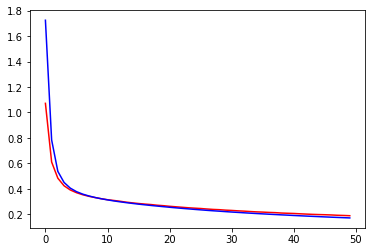

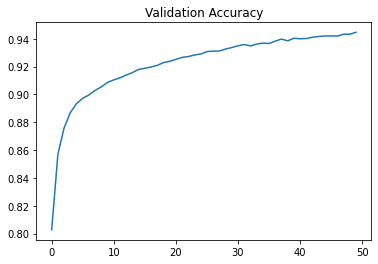

In [25]:
plt.plot(history['epoch'], history['val_loss'], 'r', label='val_loss')
plt.plot(history['epoch'], history['loss'], 'b', label='loss')
#plt.legend(loc='best')
plt.show()

plt.plot(history['epoch'], history['metric'])
plt.title('Validation Accuracy')
plt.show()

Lets save the model weights and biases

In [0]:
# saving the model
torch.save(model.state_dict(), "mnist-ffn-95acc.pth")

In [28]:
for t in model.parameters():
  print(t.shape)

torch.Size([64, 784])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])


# Lets test it out on the test data

In [0]:
# trying out the testdataset
test_dataset = torchvision.datasets.MNIST(root='data/',
                                          train=False,
                                          download=True,
                                          transform=transforms.ToTensor())

In [0]:
def predict_img(img, model):
  features = img.unsqueeze(0)
  output = model(features)
  _, preds = torch.max(output, dim=1)
  return preds.item()

In [36]:
test_dl = DataLoader(test_dataset, batch_size=100)
test_dl = DeviceDataLoader(test_dl, device)
test_loss, test_acc = evaluate(model, loss_fn, test_dl, metric=accuracy)
print(f"Loss: {test_loss}\nAccuracy: {test_acc}")

Loss: 0.17720510065555573
Accuracy: 0.9483


# Coolio bai 